In [1]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold, cross_val_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import shap
import settings

In [2]:
regression_targets = f'{settings.raw_data_folder}control/regression_targets.csv'
control = f'{settings.processed_data_folder}icd_food_control_selected_features.csv'

In [3]:
targets = pd.read_csv(regression_targets, index_col=False)

In [4]:
df = pd.read_csv(control, index_col=0)

In [5]:
df = pd.merge(targets, df, on='Country')

In [6]:
df.head()

,Deaths,Confirmed,Recovered,Country,Neoplasms,Mental and behavioural disorders,External causes of morbidity and mortality,Diseases of the musculoskeletal system and connective tissue,"Fish, Seafood",Alcoholic Beverages,Eggs,Milk - Excluding Butter,Obesity,Population,Max Latitude,Max Longitude,Annual Average Temperature
0,0.038521,0.028206,0.021108,Antigua and Barbuda,164.833333,11.500000,1.000000,11.000000,0.346861,0.226478,0.118321,0.378817,0.379391,0.000031,0.420557,0.312344,0.952521
1,0.583659,0.418513,0.431996,Argentina,66165.933333,2732.766667,5085.450000,1210.350000,0.037607,0.185313,0.548327,0.373834,0.599532,0.032320,0.073068,0.335135,0.696697
2,0.568119,0.545828,0.597178,Armenia,10735.016667,35.166667,795.500000,139.166667,0.031320,0.023402,0.438625,0.540608,0.421546,0.002069,0.627715,0.620419,0.564674
3,0.019035,0.010734,0.011205,Australia,46826.166667,9570.650000,1597.800000,1403.233333,0.115781,0.248082,0.255123,0.472108,0.644028,0.018327,0.183417,0.965855,0.848765
4,0.483634,0.455392,0.497448,Austria,21605.300000,2249.650000,532.916667,386.950000,0.074344,0.334282,0.451243,0.424990,0.444965,0.006318,0.695595,0.536621,0.533885


In [7]:
columns = df.columns.tolist()
columns.remove('Country')

In [8]:
features = df.columns.tolist()

In [9]:
features.remove('Confirmed')
features.remove('Recovered')
features.remove('Deaths')
features.remove('Country')

In [10]:
df = df[df['Deaths'] != 0]

In [11]:
df = df.drop(['Confirmed', 'Recovered'], axis=1)

In [12]:
X = df[features]

In [13]:
Y = df['Deaths']

In [14]:
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [15]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
y_pred = model.predict(X_test)

In [17]:
pred_real = []
pred_real.append(y_pred.tolist())
pred_real.append(y_test.tolist())
pred_real.append(range(0, len(y_test.tolist())))

In [18]:
indexes = y_test.index.tolist()

In [19]:
test_countries = df.loc[indexes, :]['Country']

In [20]:
pred_real_df = pd.DataFrame(pred_real).T

In [21]:
pred_real_df.columns = ['Predicted', 'Real', 'No']

In [22]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE {mae: .4f}")

MAE  0.2458


In [23]:
print('==REAL= <=> =PRED==')
i = 0
for real, pred in zip(y_test, y_pred):
    print(f"{i}:{real: .3f}  <=>  {pred: .3f}  ")
    i+=1

==REAL= <=> =PRED==
0: 0.862  <=>   0.550  
1: 0.756  <=>   0.578  
2: 0.053  <=>   0.590  
3: 0.126  <=>   0.371  
4: 0.042  <=>   0.517  
5: 0.607  <=>   0.100  
6: 0.565  <=>   0.443  
7: 0.719  <=>   0.579  
8: 0.185  <=>   0.523  
9: 0.175  <=>   0.350  
10: 0.292  <=>   0.607  
11: 0.144  <=>   0.119  
12: 0.175  <=>   0.040  
13: 0.725  <=>   0.614  
14: 0.000  <=>   0.270  
15: 0.396  <=>   0.552  
16: 0.586  <=>   0.235  
17: 0.014  <=>   0.157  
18: 0.011  <=>   0.317  
19: 0.073  <=>   0.503  
20: 0.568  <=>   0.317  
21: 0.690  <=>   0.491  
22: 0.209  <=>   0.248  
23: 0.242  <=>   0.101  


In [24]:
pred_real_df['Country'] = test_countries.tolist()

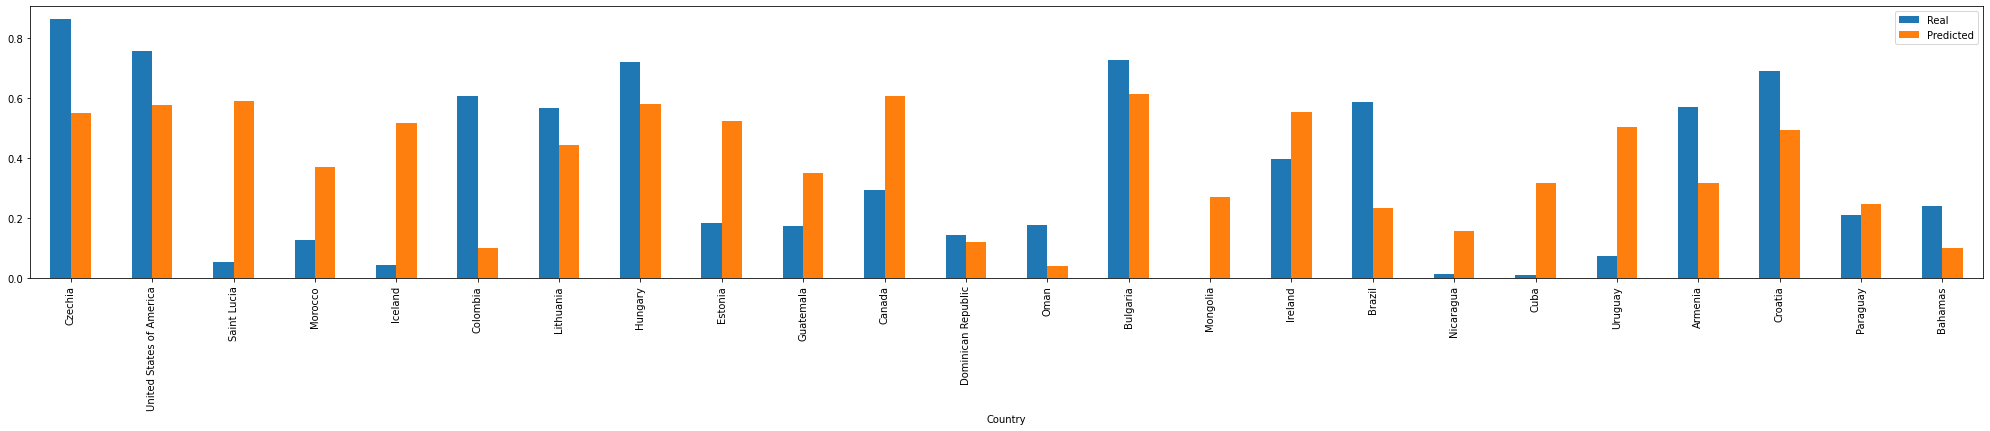

In [25]:
pred_real_df.plot(x="Country", y=["Real", "Predicted"], kind="bar", figsize=(35,5), width = 0.5)
plt.savefig(f'./icd_food_control_predictions.png', dpi=300, bbox_inches = "tight")

In [26]:
print(model.feature_importances_)

[0.01003859 0.09902329 0.0377358  0.12592675 0.03871965 0.15754007
 0.03051677 0.0325153  0.02182335 0.01472874 0.03395405 0.15952004
 0.2379576 ]


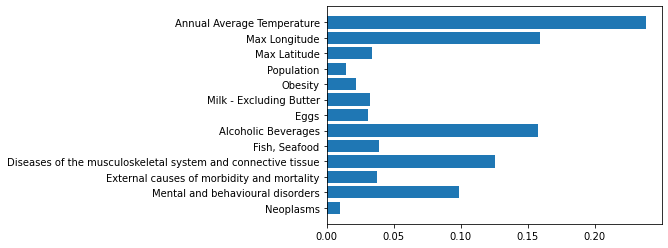

In [27]:
plt.barh(features, model.feature_importances_)
plt.show()

In [28]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

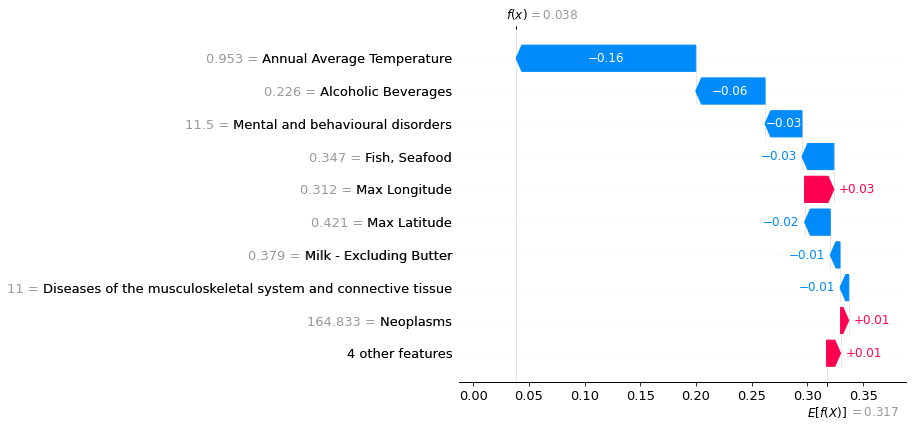

In [29]:
shap.plots.waterfall(shap_values[0])

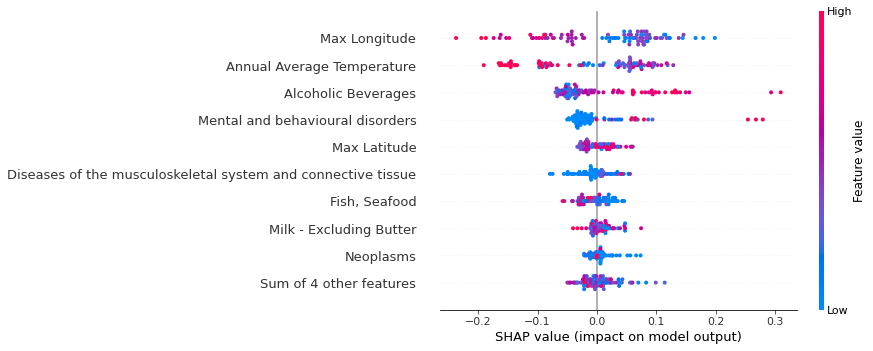

<Figure size 432x288 with 0 Axes>

In [30]:
shap.plots.beeswarm(shap_values)
plt.savefig(f'./icd_food_control_xgboost_shap.png', dpi=300, bbox_inches = "tight")

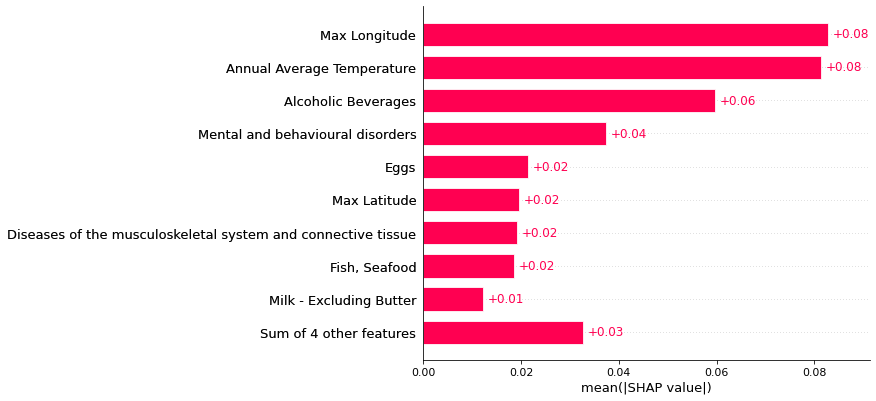

In [31]:
shap.plots.bar(shap_values)